In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:

def load_player_data(csv_path):
    return pd.read_csv(csv_path)

def split_train_validation(data, train_ratio=0.8, random_seed=42):
    np.random.seed(random_seed)
    shuffled_indices = np.random.permutation(len(data))
    training_set_size = int(len(data)*train_ratio)
    training_indices = shuffled_indices[0:training_set_size]
    validation_indices = shuffled_indices[training_set_size:]
    training_data = data.iloc[training_indices]
    validation_data = data.iloc[validation_indices]
    return training_data,validation_data


In [3]:
if __name__ == '__main__':
    csv_path = os.path.join('Model_trees_Full_Dataset/','preprocessed_datasets.csv')
    player_data = load_player_data(csv_path)
    player_data_description = player_data.describe()
    player_data_info = player_data.info()
    # one-hot encode the categorical features
    # player_data = pd.get_dummies(player_data, columns=['country_group','Position'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2224 entries, 0 to 2223
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 2224 non-null   int64 
 1   PlayerName         2224 non-null   object
 2   DraftAge           2224 non-null   int64 
 3   Country            2224 non-null   object
 4   country_group      2224 non-null   object
 5   Height             2224 non-null   int64 
 6   Weight             2224 non-null   int64 
 7   Position           2224 non-null   object
 8   DraftYear          2224 non-null   int64 
 9   Overall            2224 non-null   int64 
 10  CSS_rank           2224 non-null   int64 
 11  rs_GP              2224 non-null   int64 
 12  rs_G               2224 non-null   int64 
 13  rs_A               2224 non-null   int64 
 14  rs_P               2224 non-null   int64 
 15  rs_PIM             2224 non-null   int64 
 16  rs_PlusMinus       2224 non-null   int64 


In [4]:
all_player_data = player_data.copy()
# player_data = all_player_data[(player_data['Position'] == 'L') | (player_data['Position'] == 'R')]
player_data = all_player_data[(player_data['Position'] == 'C')]
player_data.shape

(557, 25)

In [5]:
np.unique(all_player_data['Position'])

array(['C', 'D', 'L', 'R'], dtype=object)

C:\Users\史圣镐\AppData\Local\Temp\ipykernel_32156\2142042883.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['Point_per_game'] = np.where(player_data['rs_GP'] > 0, player_data['rs_P'] / player_data['rs_GP'], 0) + \
C:\Users\史圣镐\AppData\Local\Temp\ipykernel_32156\2142042883.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['goal_diff_per_game'] = np.where(player_data['rs_GP'] > 0,
C:\Users\史圣镐\AppData\Local\Temp\ipykernel_32156\2142042883.py:23: SettingWithCopyWarning: 
A value i

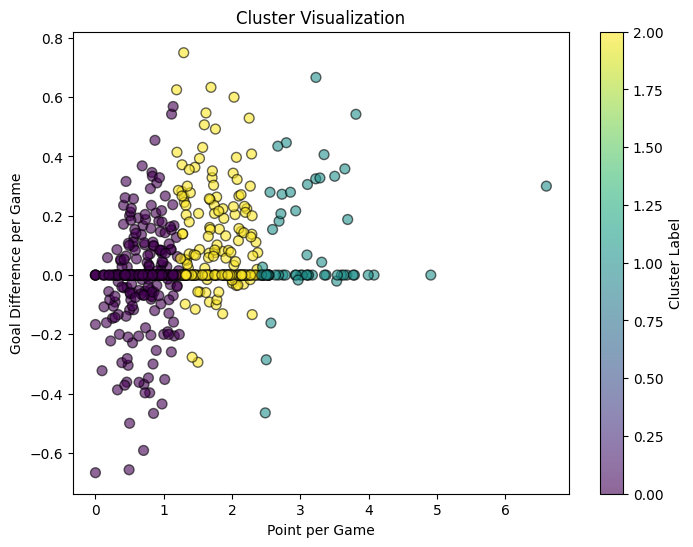

In [6]:

if __name__ == '__main__':

    # player_data['Point_per_game'] = (player_data['rs_P'] / player_data['rs_GP']).fillna(0) + (
    #             player_data['po_P'] / player_data['po_GP']).fillna(0)
    # player_data['goal_diff_per_game'] = (player_data['rs_PlusMinus'] / player_data['rs_GP']).fillna(0)

    player_data['Point_per_game'] = np.where(player_data['rs_GP'] > 0, player_data['rs_P'] / player_data['rs_GP'], 0) + \
                                    np.where(player_data['po_GP'] > 0, player_data['po_P'] / player_data['po_GP'], 0)

    player_data['goal_diff_per_game'] = np.where(player_data['rs_GP'] > 0,
                                                 player_data['rs_PlusMinus'] / player_data['rs_GP'], 0)

    cluster_columns = ['Point_per_game', 'goal_diff_per_game']
    cluster_data = player_data[cluster_columns]
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(cluster_data)

    kmeans = KMeans(n_clusters=3, random_state=42)
    # Fit the model and predict cluster indices
    cluster_labels = kmeans.fit_predict(cluster_data)

    # Assign the cluster labels to the original DataFrame
    player_data['Cluster'] = cluster_labels

    plt.figure(figsize=(8, 6))
    plt.scatter(player_data['Point_per_game'], player_data['goal_diff_per_game'], c=player_data['Cluster'],
                cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
    plt.title('Cluster Visualization')
    plt.xlabel('Point per Game')
    plt.ylabel('Goal Difference per Game')
    plt.colorbar(label='Cluster Label')
    plt.show()

C:\Users\史圣镐\PycharmProjects\NHLClassification\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


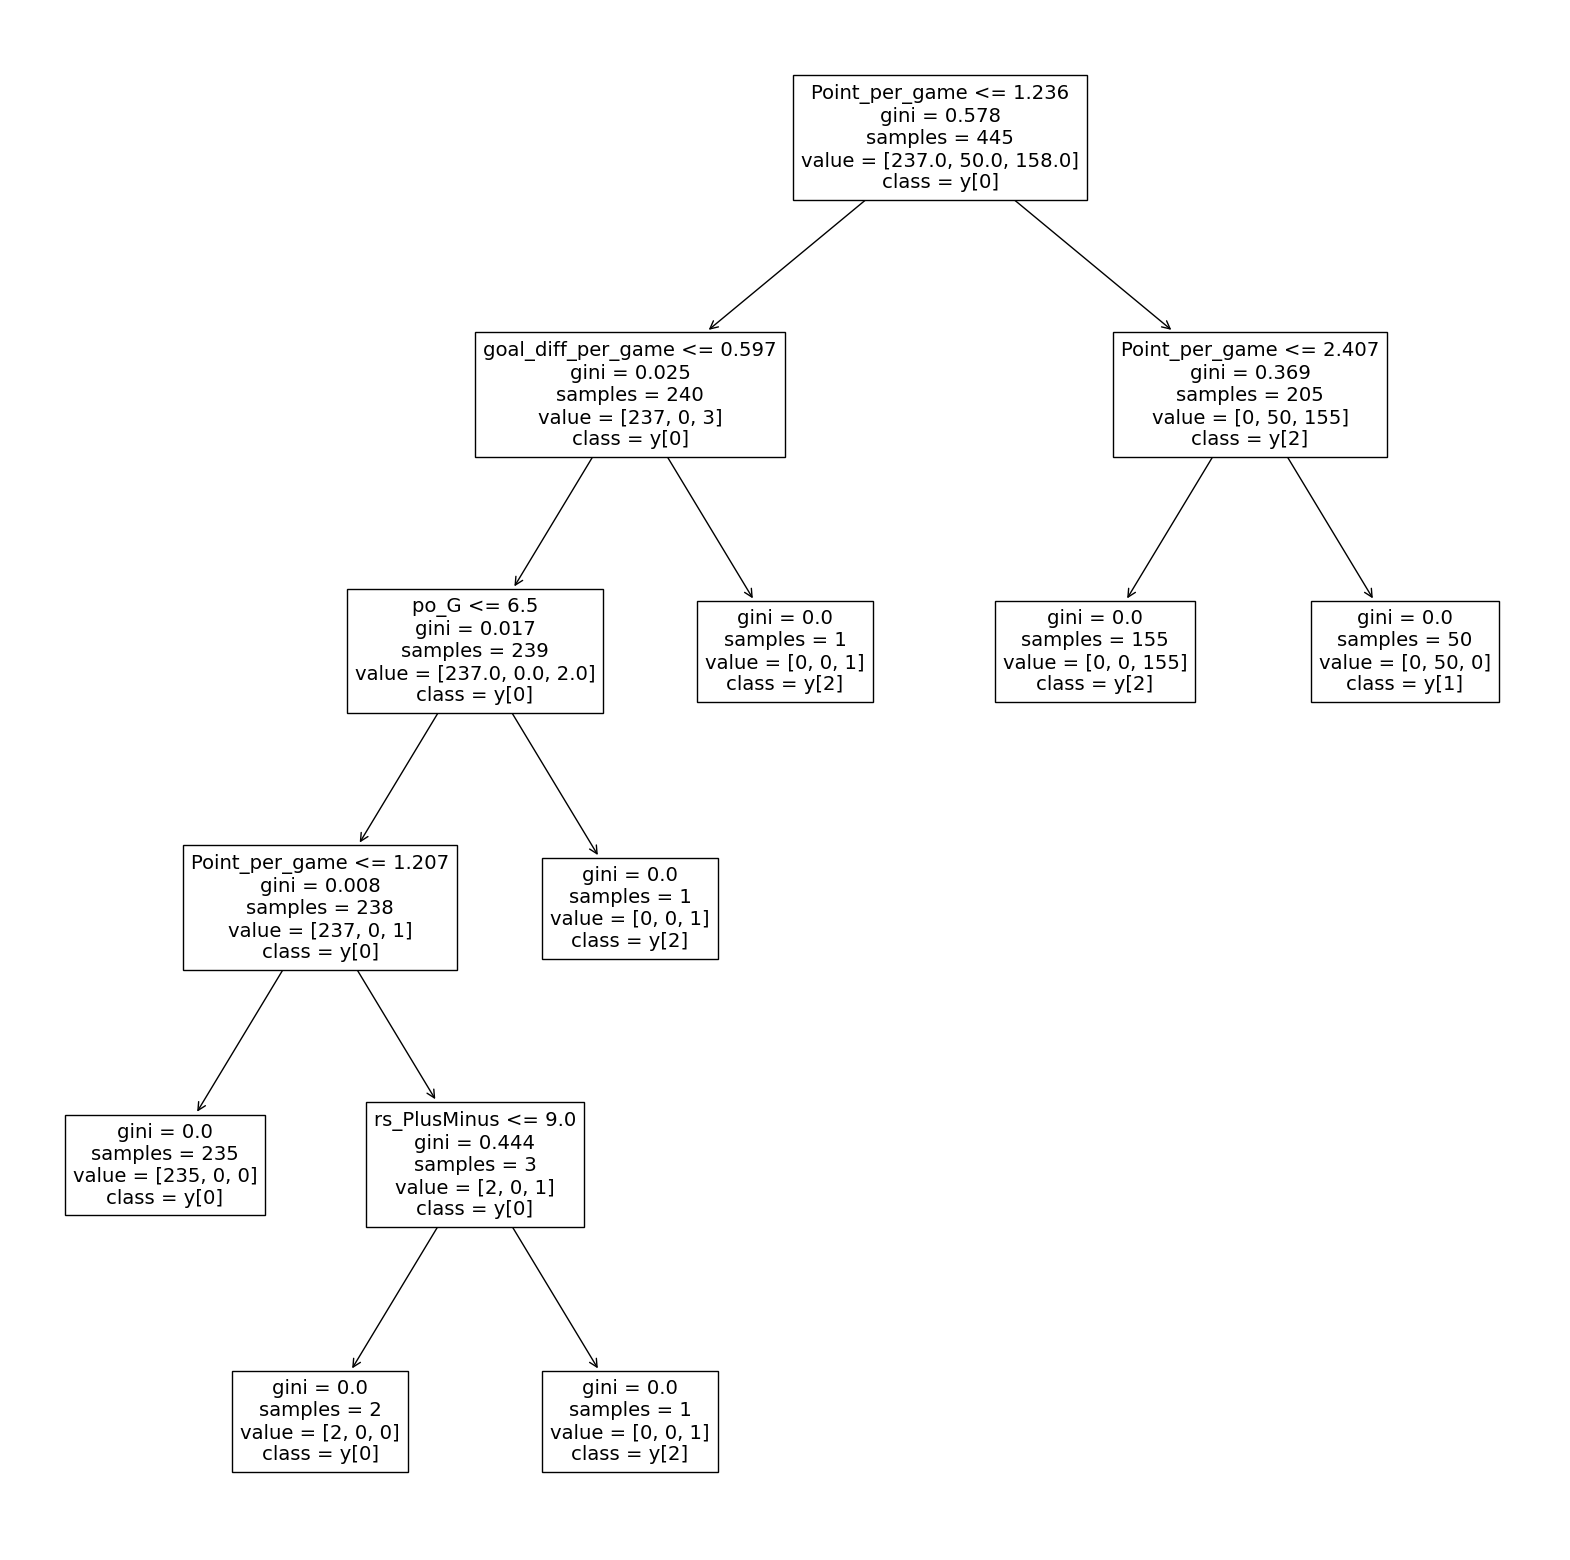

In [7]:
# one-hot encode the categorical features
player_data = pd.get_dummies(player_data, columns=['country_group'])
# tree model begins here
training_data, validation_data = split_train_validation(player_data,0.8)
# input features
X_train = training_data.drop(columns=['id', 'PlayerName', 'GP_greater_than_0','Country','Position','Cluster'])
X_validation = validation_data.drop(columns=['id', 'PlayerName', 'GP_greater_than_0','Country','Position','Cluster'])
# output label
Y_train = training_data['Cluster']
Y_validation = validation_data['Cluster']
#
# label_encoder = LabelEncoder()
# Y_train_encoded = label_encoder.fit_transform(Y_train)
# Y_validation_encoded = label_encoder.fit_transform(Y_validation)

tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, Y_train)

Y_pred = tree_model.predict(X_validation)
accuracy = accuracy_score(Y_validation,Y_pred)

# predict on a single player data, make sure the input feature is fed in 2d array
tree_model.predict(X_validation.iloc[:1])

X_combined = np.concatenate([X_train, X_validation])
Y_combined = np.concatenate([Y_train, Y_validation])

Y_pred_combined = tree_model.predict(X_combined)
combined_accuracy = accuracy_score(Y_combined, Y_pred_combined)

plt.figure(figsize=(20,20))
plot_tree(tree_model, feature_names=X_train.columns, class_names=True)
plt.show()

In [8]:
accuracy

0.9910714285714286